# Co-occurence and causality matrix calculation for the Epic Kitchens dataset

Causality matrix will be computed by:
- Considering pairs of verb-noun in epic kitchens
- For each pair of verb-noun, adding occurences of each other pair that comes after it
    - version 1: only count what comes right after
    - version 2: count every action that comes after the given pair, but reduce contribution exponentially according to temporal distance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm import tqdm
from build_causality_matrix import *
from decays import *
import pickle
import json
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
# Load Epic kitchens train annotations
train_annotations = pd.read_csv('../epic-kitchens-100-annotations/EPIC_100_train.csv')

# Show statistics
print('Train annotations:')
print("Size", train_annotations.shape)

train_annotations.head(20)


Train annotations:
Size (67217, 15)


,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01_01_0,P01,P01_01,00:00:01.089,00:00:00.14,00:00:03.37,8,202,open door,open,3,door,3,['door'],[3]
1,P01_01_1,P01,P01_01,00:00:02.629,00:00:04.37,00:00:06.17,262,370,turn on light,turn-on,6,light,114,['light'],[114]
2,P01_01_10,P01,P01_01,00:00:23.340,00:00:24.97,00:00:26.20,1498,1572,open drawer,open,3,drawer,8,['drawer'],[8]
3,P01_01_100,P01,P01_01,00:07:57.919,00:07:59.75,00:08:00.88,28785,28852,take cup,take,0,cup,13,['cup'],[13]
4,P01_01_101,P01,P01_01,00:08:00.020,00:08:01.47,00:08:02.21,28888,28932,open cupboard,open,3,cupboard,3,['cupboard'],[3]
5,P01_01_102,P01,P01_01,00:08:01.229,00:08:02.13,00:08:03.00,28927,28980,put cup into cupboard,put-into,5,cup,13,"['cup', 'cupboard']","[13, 3]"
6,P01_01_103,P01,P01_01,00:08:03.919,00:08:05.22,00:08:07.21,29113,29232,take container and lid,take,0,container,21,"['container', 'lid']","[21, 6]"
7,P01_01_104,P01,P01_01,00:08:07.610,00:08:08.38,00:08:09.12,29302,29347,put container on top of counter,put-on,1,container,21,"['container', 'top:counter']","[21, 42]"
8,P01_01_105,P01,P01_01,00:08:09.860,00:08:12.00,00:08:12.74,29520,29564,open container,open,3,container,21,['container'],[21]
9,P01_01_106,P01,P01_01,00:08:12.900,00:08:13.22,00:08:14.37,29593,29662,put container inside container,put-inside,5,container,21,"['container', 'container']","[21, 21]"


In [3]:
# Sort train annotations by video id, then narration id
train_annotations = train_annotations.sort_values(by=['video_id', 'narration_id'])

train_annotations.head()

,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01_01_0,P01,P01_01,00:00:01.089,00:00:00.14,00:00:03.37,8,202,open door,open,3,door,3,['door'],[3]
1,P01_01_1,P01,P01_01,00:00:02.629,00:00:04.37,00:00:06.17,262,370,turn on light,turn-on,6,light,114,['light'],[114]
2,P01_01_10,P01,P01_01,00:00:23.340,00:00:24.97,00:00:26.20,1498,1572,open drawer,open,3,drawer,8,['drawer'],[8]
3,P01_01_100,P01,P01_01,00:07:57.919,00:07:59.75,00:08:00.88,28785,28852,take cup,take,0,cup,13,['cup'],[13]
4,P01_01_101,P01,P01_01,00:08:00.020,00:08:01.47,00:08:02.21,28888,28932,open cupboard,open,3,cupboard,3,['cupboard'],[3]


In [4]:
# Get count of actions in train set
print(train_annotations['verb'].value_counts())
print()
print(train_annotations['noun'].value_counts())

pick-up      9868
put-down     7726
open         4851
close        3463
take         3412
             ... 
pat-into        1
stem            1
tear-into       1
strain-in       1
flip-with       1
Name: verb, Length: 856, dtype: int64

tap                 3567
plate               2186
knife               2092
spoon               1806
cupboard            1786
                    ... 
bowl:onion             1
rubber                 1
box:blender            1
lid:clip:top:jar       1
package:paprika        1
Name: noun, Length: 2032, dtype: int64


In [5]:
train_annotations = add_narration_number(train_annotations)
print(type(train_annotations["narration_number"].iloc[0]))
train_annotations = train_annotations.sort_values(by=['video_id','start_frame'])
train_annotations.head(50)

<class 'numpy.int64'>


,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes,narration_number
0,P01_01_0,P01,P01_01,00:00:01.089,00:00:00.14,00:00:03.37,8,202,open door,open,3,door,3,['door'],[3],0
1,P01_01_1,P01,P01_01,00:00:02.629,00:00:04.37,00:00:06.17,262,370,turn on light,turn-on,6,light,114,['light'],[114],1
111,P01_01_2,P01,P01_01,00:00:05.349,00:00:06.98,00:00:09.49,418,569,close door,close,4,door,3,['door'],[3],2
222,P01_01_3,P01,P01_01,00:00:11.040,00:00:12.77,00:00:13.99,766,839,open fridge,open,3,fridge,12,['fridge'],[12],3
263,P01_01_4,P01,P01_01,00:00:13.360,00:00:15.25,00:00:16.40,915,983,take celery,take,0,celery,223,['celery'],[223],4
274,P01_01_5,P01,P01_01,00:00:14.990,00:00:16.50,00:00:18.06,990,1083,take container,take,0,container,21,['container'],[21],5
285,P01_01_6,P01,P01_01,00:00:18.850,00:00:18.19,00:00:21.14,1091,1268,take tofu,take,0,tofu,81,['tofu'],[81],6
296,P01_01_7,P01,P01_01,00:00:20.410,00:00:21.91,00:00:23.33,1314,1399,close fridge,close,4,fridge,12,['fridge'],[12],7
307,P01_01_8,P01,P01_01,00:00:21.650,00:00:23.18,00:00:24.29,1390,1457,open fridge,open,3,fridge,12,['fridge'],[12],8
318,P01_01_9,P01,P01_01,00:00:24.490,00:00:24.48,00:00:27.94,1468,1676,take carrots and,take,0,carrot,41,['carrot'],[41],9


## Alternatives given narration overlap:
1. Consider only actions that happen after start time
2. Consider only actions that happen after end time
3. Consider only actions that end after end time
4. Combination of the options above

Problem: 
a. some actions overlap almost perfectly 
b. some of these are repeated actions


**Current solution: only counting actions that a) start after the current action has started, and b) start at most one second before the end of the current action**


In [7]:
train_annotations = prepare_EK_df(train_annotations)
empty_cm = init_causality_matrix(get_unique_nv_combos(train_annotations))

/home/camilo/Dropbox/Graduate Studies/MIT/Research/frl_projects/frl_causality_project/build_causality_matrix.py:139: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["verb_nouns"] = df["verb_nouns"].str.replace("[","")
/home/camilo/Dropbox/Graduate Studies/MIT/Research/frl_projects/frl_causality_project/build_causality_matrix.py:140: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["verb_nouns"] = df["verb_nouns"].str.replace("]","")


len(unique_nv_combos) 13656


In [7]:
cm = build_causality_matrix_weighted(train_annotations, linear_decay, empty_cm)

  0%|          | 0/495 [00:00<?, ?it/s]

len(unique_nv_combos) 13656
Causality matrix initialized
looking at group P01_01 with len 329


  0%|          | 1/495 [00:37<5:12:23, 37.94s/it]

looking at group P01_02 with len 145


  0%|          | 2/495 [00:45<2:46:42, 20.29s/it]

looking at group P01_03 with len 42


  1%|          | 3/495 [00:46<1:32:37, 11.29s/it]

looking at group P01_04 with len 32


  1%|          | 4/495 [00:46<57:01,  6.97s/it]  

looking at group P01_05 with len 259


  1%|          | 5/495 [01:09<1:44:03, 12.74s/it]

looking at group P01_06 with len 119


  1%|          | 6/495 [01:14<1:21:50, 10.04s/it]

looking at group P01_07 with len 57


  1%|▏         | 7/495 [01:15<57:55,  7.12s/it]  

looking at group P01_08 with len 32


  2%|▏         | 8/495 [01:15<40:10,  4.95s/it]

looking at group P01_09 with len 881


  2%|▏         | 10/495 [04:46<6:26:16, 47.79s/it]

looking at group P01_10 with len 26
looking at group P01_102 with len 127


  2%|▏         | 11/495 [04:50<4:38:27, 34.52s/it]

looking at group P01_103 with len 98


  2%|▏         | 12/495 [04:53<3:19:47, 24.82s/it]

looking at group P01_104 with len 93


  3%|▎         | 13/495 [04:55<2:24:16, 17.96s/it]

looking at group P01_105 with len 790


  3%|▎         | 14/495 [07:41<8:22:35, 62.69s/it]

looking at group P01_106 with len 247


  3%|▎         | 15/495 [07:57<6:27:50, 48.48s/it]

looking at group P01_107 with len 62


  3%|▎         | 16/495 [07:57<4:32:47, 34.17s/it]

looking at group P01_108 with len 66


  3%|▎         | 17/495 [07:59<3:12:56, 24.22s/it]

looking at group P01_109 with len 918


  4%|▎         | 18/495 [11:50<11:26:39, 86.37s/it]

looking at group P01_16 with len 73


  4%|▍         | 19/495 [11:51<8:03:14, 60.91s/it] 

looking at group P01_17 with len 287


  4%|▍         | 20/495 [12:12<6:27:28, 48.94s/it]

looking at group P01_18 with len 689


  4%|▍         | 21/495 [15:00<11:07:19, 84.47s/it]

looking at group P01_19 with len 137


  4%|▍         | 22/495 [15:12<8:16:39, 63.00s/it] 

looking at group P02_01 with len 87


  5%|▍         | 23/495 [15:18<5:58:54, 45.62s/it]

looking at group P02_02 with len 89


  5%|▍         | 24/495 [15:22<4:20:39, 33.20s/it]

looking at group P02_03 with len 362


  5%|▌         | 25/495 [16:49<6:26:03, 49.29s/it]

looking at group P02_04 with len 168


  5%|▌         | 26/495 [16:58<4:51:16, 37.26s/it]

looking at group P02_05 with len 5
looking at group P02_06 with len 371


  6%|▌         | 28/495 [17:55<4:19:44, 33.37s/it]

looking at group P02_07 with len 53


  6%|▌         | 29/495 [17:57<3:17:33, 25.44s/it]

looking at group P02_08 with len 33


  6%|▌         | 30/495 [17:57<2:26:34, 18.91s/it]

looking at group P02_09 with len 573


  6%|▋         | 31/495 [19:56<5:55:41, 45.99s/it]

looking at group P02_10 with len 12
looking at group P02_101 with len 111


  7%|▋         | 33/495 [20:00<3:25:54, 26.74s/it]

looking at group P02_102 with len 110


  7%|▋         | 34/495 [20:04<2:45:06, 21.49s/it]

looking at group P02_103 with len 47


  7%|▋         | 35/495 [20:05<2:04:51, 16.29s/it]

looking at group P02_104 with len 182


  7%|▋         | 36/495 [20:25<2:11:05, 17.14s/it]

looking at group P02_105 with len 199


  7%|▋         | 37/495 [20:40<2:07:32, 16.71s/it]

looking at group P02_107 with len 52


  8%|▊         | 38/495 [20:42<1:33:57, 12.34s/it]

looking at group P02_108 with len 451


  8%|▊         | 39/495 [21:44<3:22:41, 26.67s/it]

looking at group P02_109 with len 187


  8%|▊         | 41/495 [22:00<2:05:41, 16.61s/it]

looking at group P02_11 with len 20
looking at group P02_110 with len 50


  9%|▊         | 43/495 [22:01<1:04:10,  8.52s/it]

looking at group P02_111 with len 17
looking at group P02_112 with len 317


  9%|▉         | 44/495 [22:55<2:46:52, 22.20s/it]

looking at group P02_113 with len 184


  9%|▉         | 46/495 [23:13<1:49:57, 14.69s/it]

looking at group P02_114 with len 16
looking at group P02_115 with len 45


  9%|▉         | 47/495 [23:15<1:19:40, 10.67s/it]

looking at group P02_116 with len 32


 10%|▉         | 48/495 [23:15<56:51,  7.63s/it]  

looking at group P02_118 with len 290


 10%|█         | 50/495 [23:59<1:36:38, 13.03s/it]

looking at group P02_119 with len 16
looking at group P02_120 with len 221


 10%|█         | 51/495 [24:41<2:39:41, 21.58s/it]

looking at group P02_121 with len 99


 11%|█         | 52/495 [24:47<2:05:06, 16.94s/it]

looking at group P02_122 with len 214


 11%|█         | 53/495 [25:16<2:30:49, 20.47s/it]

looking at group P02_123 with len 473


 11%|█         | 54/495 [28:02<7:51:45, 64.18s/it]

looking at group P02_124 with len 93


 11%|█         | 55/495 [28:09<5:45:52, 47.16s/it]

looking at group P02_126 with len 60


 12%|█▏        | 57/495 [28:13<2:54:28, 23.90s/it]

looking at group P02_127 with len 11
looking at group P02_128 with len 63


 12%|█▏        | 58/495 [28:17<2:10:53, 17.97s/it]

looking at group P02_129 with len 494


 12%|█▏        | 59/495 [30:58<7:21:56, 60.82s/it]

looking at group P02_130 with len 331


 12%|█▏        | 60/495 [31:47<6:55:30, 57.31s/it]

looking at group P02_131 with len 273


 12%|█▏        | 61/495 [32:22<6:06:29, 50.67s/it]

looking at group P02_132 with len 89


 13%|█▎        | 62/495 [32:27<4:25:29, 36.79s/it]

looking at group P02_133 with len 34


 13%|█▎        | 63/495 [32:27<3:06:31, 25.91s/it]

looking at group P02_134 with len 14
looking at group P02_135 with len 116


 13%|█▎        | 65/495 [32:34<1:50:17, 15.39s/it]

looking at group P03_02 with len 137


 13%|█▎        | 66/495 [32:42<1:36:56, 13.56s/it]

looking at group P03_03 with len 24


 14%|█▎        | 67/495 [32:42<1:12:00, 10.09s/it]

looking at group P03_04 with len 361


 14%|█▎        | 68/495 [33:46<2:56:14, 24.76s/it]

looking at group P03_05 with len 66


 14%|█▍        | 69/495 [33:49<2:12:51, 18.71s/it]

looking at group P03_06 with len 32


 14%|█▍        | 70/495 [33:50<1:36:21, 13.60s/it]

looking at group P03_07 with len 48


 14%|█▍        | 71/495 [33:52<1:11:53, 10.17s/it]

looking at group P03_08 with len 9
looking at group P03_09 with len 180


 15%|█▍        | 73/495 [34:14<1:15:10, 10.69s/it]

looking at group P03_10 with len 41


 15%|█▍        | 74/495 [34:15<58:14,  8.30s/it]  

looking at group P03_101 with len 351


 15%|█▌        | 75/495 [35:21<2:42:15, 23.18s/it]

looking at group P03_102 with len 84


 15%|█▌        | 76/495 [35:24<2:03:40, 17.71s/it]

looking at group P03_106 with len 32


 16%|█▌        | 77/495 [35:25<1:30:22, 12.97s/it]

looking at group P03_107 with len 109


 16%|█▌        | 79/495 [35:32<55:42,  8.04s/it]  

looking at group P03_108 with len 19
looking at group P03_109 with len 411


 16%|█▋        | 81/495 [36:45<2:12:32, 19.21s/it]

looking at group P03_11 with len 19
looking at group P03_110 with len 14


 17%|█▋        | 82/495 [36:45<1:33:16, 13.55s/it]

looking at group P03_111 with len 35


 17%|█▋        | 83/495 [36:46<1:06:29,  9.68s/it]

looking at group P03_112 with len 171


 17%|█▋        | 84/495 [36:59<1:13:36, 10.74s/it]

looking at group P03_113 with len 62


 17%|█▋        | 86/495 [37:01<39:17,  5.76s/it]  

looking at group P03_114 with len 17
looking at group P03_115 with len 14
looking at group P03_116 with len 31


 18%|█▊        | 88/495 [37:02<21:43,  3.20s/it]

looking at group P03_117 with len 259


 18%|█▊        | 89/495 [37:35<1:11:45, 10.61s/it]

looking at group P03_118 with len 66


 18%|█▊        | 90/495 [37:37<55:53,  8.28s/it]  

looking at group P03_119 with len 211


 18%|█▊        | 91/495 [37:56<1:15:52, 11.27s/it]

looking at group P03_12 with len 7
looking at group P03_120 with len 256


 19%|█▉        | 93/495 [38:21<1:19:35, 11.88s/it]

looking at group P03_121 with len 68


 19%|█▉        | 94/495 [38:23<1:03:36,  9.52s/it]

looking at group P03_122 with len 12
looking at group P03_123 with len 98


 19%|█▉        | 96/495 [38:27<43:16,  6.51s/it]  

looking at group P03_13 with len 21


 20%|█▉        | 97/495 [38:27<33:48,  5.10s/it]

looking at group P03_14 with len 43


 20%|█▉        | 98/495 [38:28<26:57,  4.07s/it]

looking at group P03_15 with len 3
looking at group P03_16 with len 39


 20%|██        | 101/495 [38:29<13:13,  2.01s/it]

looking at group P03_17 with len 25
looking at group P03_18 with len 8
looking at group P03_19 with len 168


 21%|██        | 103/495 [38:42<23:59,  3.67s/it]

looking at group P03_20 with len 74


 21%|██        | 104/495 [38:44<22:34,  3.46s/it]

looking at group P03_27 with len 27


 21%|██        | 105/495 [38:45<17:36,  2.71s/it]

looking at group P03_28 with len 41


 21%|██▏       | 106/495 [38:45<14:12,  2.19s/it]

looking at group P04_01 with len 262


 22%|██▏       | 107/495 [39:15<1:00:59,  9.43s/it]

looking at group P04_02 with len 329


 22%|██▏       | 108/495 [40:05<2:13:23, 20.68s/it]

looking at group P04_03 with len 218


 22%|██▏       | 109/495 [40:30<2:19:57, 21.76s/it]

looking at group P04_04 with len 152


 22%|██▏       | 110/495 [40:40<1:57:56, 18.38s/it]

looking at group P04_05 with len 309


 22%|██▏       | 111/495 [41:15<2:29:08, 23.30s/it]

looking at group P04_06 with len 117


 23%|██▎       | 112/495 [41:19<1:53:37, 17.80s/it]

looking at group P04_07 with len 29


 23%|██▎       | 114/495 [41:20<56:38,  8.92s/it]  

looking at group P04_08 with len 20
looking at group P04_09 with len 35


 23%|██▎       | 115/495 [41:20<40:24,  6.38s/it]

looking at group P04_10 with len 106


 23%|██▎       | 116/495 [41:24<35:40,  5.65s/it]

looking at group P04_101 with len 241


 24%|██▎       | 117/495 [41:46<1:05:30, 10.40s/it]

looking at group P04_102 with len 63


 24%|██▍       | 118/495 [41:47<49:00,  7.80s/it]  

looking at group P04_103 with len 39


 24%|██▍       | 119/495 [41:48<35:29,  5.66s/it]

looking at group P04_104 with len 294


 24%|██▍       | 120/495 [42:21<1:27:08, 13.94s/it]

looking at group P04_106 with len 115


 24%|██▍       | 121/495 [42:26<1:09:22, 11.13s/it]

looking at group P04_107 with len 940


 25%|██▍       | 122/495 [46:56<9:12:39, 88.90s/it]

looking at group P04_108 with len 101


 25%|██▍       | 123/495 [46:59<6:30:32, 62.99s/it]

looking at group P04_109 with len 538


 25%|██▌       | 124/495 [48:27<7:16:35, 70.61s/it]

looking at group P04_11 with len 25


 25%|██▌       | 125/495 [48:28<5:05:13, 49.50s/it]

looking at group P04_110 with len 401


 25%|██▌       | 126/495 [49:27<5:23:22, 52.58s/it]

looking at group P04_111 with len 69


 26%|██▌       | 127/495 [49:29<3:48:53, 37.32s/it]

looking at group P04_112 with len 257


 26%|██▌       | 128/495 [49:50<3:18:35, 32.47s/it]

looking at group P04_113 with len 517


 26%|██▌       | 129/495 [52:08<6:30:33, 64.03s/it]

looking at group P04_114 with len 84


 26%|██▋       | 130/495 [52:13<4:42:01, 46.36s/it]

looking at group P04_115 with len 133


 26%|██▋       | 131/495 [52:25<3:39:11, 36.13s/it]

looking at group P04_116 with len 223


 27%|██▋       | 132/495 [52:49<3:16:01, 32.40s/it]

looking at group P04_117 with len 168


 27%|██▋       | 133/495 [53:04<2:44:34, 27.28s/it]

looking at group P04_118 with len 54


 27%|██▋       | 134/495 [53:06<1:58:06, 19.63s/it]

looking at group P04_119 with len 288


 27%|██▋       | 136/495 [53:48<1:49:55, 18.37s/it]

looking at group P04_12 with len 16
looking at group P04_120 with len 376


 28%|██▊       | 137/495 [55:13<3:49:31, 38.47s/it]

looking at group P04_121 with len 717


 28%|██▊       | 138/495 [58:19<8:12:31, 82.78s/it]

looking at group P04_13 with len 41


 28%|██▊       | 139/495 [58:20<5:44:46, 58.11s/it]

looking at group P04_14 with len 9
looking at group P04_15 with len 1
looking at group P04_16 with len 43


 29%|██▉       | 143/495 [58:21<1:58:22, 20.18s/it]

looking at group P04_17 with len 22
looking at group P04_18 with len 26


 29%|██▉       | 144/495 [58:21<1:30:58, 15.55s/it]

looking at group P04_19 with len 5
looking at group P04_20 with len 13
looking at group P04_21 with len 24


 30%|██▉       | 148/495 [58:21<36:50,  6.37s/it]  

looking at group P04_22 with len 22
looking at group P04_23 with len 93


 30%|███       | 149/495 [58:25<33:01,  5.73s/it]

looking at group P05_01 with len 49


 30%|███       | 150/495 [58:26<26:29,  4.61s/it]

looking at group P05_02 with len 56


 31%|███       | 151/495 [58:27<21:20,  3.72s/it]

looking at group P05_03 with len 163


 31%|███       | 152/495 [58:35<28:11,  4.93s/it]

looking at group P05_04 with len 60


 31%|███       | 153/495 [58:36<22:10,  3.89s/it]

looking at group P05_05 with len 30


 31%|███       | 154/495 [58:36<16:21,  2.88s/it]

looking at group P05_06 with len 38


 31%|███▏      | 155/495 [58:37<12:27,  2.20s/it]

looking at group P05_08 with len 139


 32%|███▏      | 156/495 [58:43<18:53,  3.34s/it]

looking at group P06_01 with len 23


 32%|███▏      | 157/495 [58:43<13:41,  2.43s/it]

looking at group P06_02 with len 6
looking at group P06_03 with len 128


 32%|███▏      | 159/495 [58:49<14:40,  2.62s/it]

looking at group P06_05 with len 224


 32%|███▏      | 160/495 [59:07<36:13,  6.49s/it]

looking at group P06_07 with len 256


 33%|███▎      | 161/495 [59:28<56:35, 10.16s/it]

looking at group P06_08 with len 6
looking at group P06_09 with len 178


 33%|███▎      | 163/495 [59:39<45:13,  8.17s/it]

looking at group P06_101 with len 422


 33%|███▎      | 164/495 [1:00:34<1:44:56, 19.02s/it]

looking at group P06_102 with len 129


 33%|███▎      | 165/495 [1:00:38<1:24:34, 15.38s/it]

looking at group P06_103 with len 177


 34%|███▎      | 166/495 [1:00:48<1:16:58, 14.04s/it]

looking at group P06_104 with len 37


 34%|███▎      | 167/495 [1:00:49<56:26, 10.33s/it]  

looking at group P06_105 with len 29


 34%|███▍      | 168/495 [1:00:49<40:50,  7.49s/it]

looking at group P06_106 with len 53


 34%|███▍      | 169/495 [1:00:50<30:39,  5.64s/it]

looking at group P06_107 with len 64


 34%|███▍      | 170/495 [1:00:51<23:32,  4.35s/it]

looking at group P06_108 with len 171


 35%|███▍      | 171/495 [1:00:59<29:27,  5.46s/it]

looking at group P06_109 with len 10
looking at group P06_110 with len 15
looking at group P06_113 with len 122


 36%|███▌      | 176/495 [1:01:04<11:10,  2.10s/it]

looking at group P07_01 with len 15
looking at group P07_02 with len 15
looking at group P07_03 with len 31


 36%|███▌      | 177/495 [1:01:04<09:12,  1.74s/it]

looking at group P07_04 with len 154


 36%|███▌      | 178/495 [1:01:12<16:09,  3.06s/it]

looking at group P07_05 with len 34


 36%|███▌      | 179/495 [1:01:12<12:45,  2.42s/it]

looking at group P07_06 with len 29


 36%|███▋      | 180/495 [1:01:12<09:52,  1.88s/it]

looking at group P07_07 with len 53


 37%|███▋      | 182/495 [1:01:13<06:26,  1.23s/it]

looking at group P07_08 with len 25
looking at group P07_09 with len 46


 37%|███▋      | 183/495 [1:01:14<05:35,  1.08s/it]

looking at group P07_10 with len 330


 37%|███▋      | 184/495 [1:01:51<59:14, 11.43s/it]

looking at group P07_101 with len 81


 37%|███▋      | 185/495 [1:01:54<45:57,  8.89s/it]

looking at group P07_102 with len 60


 38%|███▊      | 187/495 [1:01:55<24:18,  4.73s/it]

looking at group P07_103 with len 18
looking at group P07_106 with len 5
looking at group P07_107 with len 61


 38%|███▊      | 189/495 [1:01:57<14:31,  2.85s/it]

looking at group P07_11 with len 28


 38%|███▊      | 190/495 [1:01:57<11:13,  2.21s/it]

looking at group P07_110 with len 85


 39%|███▊      | 191/495 [1:01:59<10:56,  2.16s/it]

looking at group P07_111 with len 52


 39%|███▉      | 193/495 [1:02:00<06:35,  1.31s/it]

looking at group P07_112 with len 20
looking at group P07_113 with len 171


 39%|███▉      | 194/495 [1:02:07<15:31,  3.09s/it]

looking at group P07_114 with len 44


 39%|███▉      | 195/495 [1:02:08<11:41,  2.34s/it]

looking at group P07_115 with len 66


 40%|███▉      | 196/495 [1:02:09<09:50,  1.97s/it]

looking at group P07_116 with len 31


 40%|███▉      | 197/495 [1:02:09<07:16,  1.47s/it]

looking at group P07_117 with len 131


 40%|████      | 198/495 [1:02:13<11:25,  2.31s/it]

looking at group P08_01 with len 156


 40%|████      | 199/495 [1:02:19<16:33,  3.36s/it]

looking at group P08_02 with len 34


 40%|████      | 200/495 [1:02:19<11:58,  2.44s/it]

looking at group P08_03 with len 34


 41%|████      | 201/495 [1:02:20<08:47,  1.79s/it]

looking at group P08_04 with len 66


 41%|████      | 202/495 [1:02:21<07:59,  1.64s/it]

looking at group P08_05 with len 371


 41%|████      | 203/495 [1:02:56<56:27, 11.60s/it]

looking at group P08_06 with len 122


 41%|████      | 204/495 [1:02:59<44:27,  9.17s/it]

looking at group P08_07 with len 9
looking at group P08_08 with len 36


 42%|████▏     | 206/495 [1:03:00<24:09,  5.01s/it]

looking at group P08_11 with len 51


 42%|████▏     | 207/495 [1:03:00<18:52,  3.93s/it]

looking at group P08_12 with len 8
looking at group P08_13 with len 4
looking at group P08_18 with len 113


 43%|████▎     | 211/495 [1:03:04<09:29,  2.01s/it]

looking at group P08_19 with len 25
looking at group P08_20 with len 40


 43%|████▎     | 212/495 [1:03:04<07:48,  1.65s/it]

looking at group P08_21 with len 341


 43%|████▎     | 213/495 [1:03:31<35:58,  7.66s/it]

looking at group P08_22 with len 37


 43%|████▎     | 214/495 [1:03:31<27:06,  5.79s/it]

looking at group P08_23 with len 294


 43%|████▎     | 215/495 [1:03:48<41:12,  8.83s/it]

looking at group P08_24 with len 117


 44%|████▎     | 216/495 [1:03:51<33:27,  7.20s/it]

looking at group P08_25 with len 7
looking at group P08_26 with len 103


 44%|████▍     | 218/495 [1:03:54<20:56,  4.54s/it]

looking at group P08_27 with len 41


 44%|████▍     | 219/495 [1:03:54<16:15,  3.54s/it]

looking at group P08_28 with len 15
looking at group P09_01 with len 3
looking at group P09_02 with len 68


 45%|████▍     | 222/495 [1:03:55<08:42,  1.91s/it]

looking at group P09_03 with len 34


 45%|████▌     | 223/495 [1:03:55<07:12,  1.59s/it]

looking at group P09_04 with len 19
looking at group P09_05 with len 50


 45%|████▌     | 225/495 [1:03:56<05:03,  1.13s/it]

looking at group P09_06 with len 69


 46%|████▌     | 226/495 [1:03:57<04:54,  1.09s/it]

looking at group P09_103 with len 44


 46%|████▌     | 227/495 [1:03:57<04:11,  1.07it/s]

looking at group P09_104 with len 85


 46%|████▌     | 228/495 [1:03:59<04:51,  1.09s/it]

looking at group P09_105 with len 36


 46%|████▋     | 230/495 [1:03:59<03:02,  1.45it/s]

looking at group P09_106 with len 27
looking at group P10_01 with len 123


 47%|████▋     | 231/495 [1:04:03<06:13,  1.42s/it]

looking at group P10_02 with len 150


 47%|████▋     | 232/495 [1:04:07<09:58,  2.28s/it]

looking at group P10_04 with len 506


 47%|████▋     | 233/495 [1:04:59<1:12:06, 16.51s/it]

looking at group P11_01 with len 76


 47%|████▋     | 235/495 [1:05:00<36:56,  8.52s/it]  

looking at group P11_02 with len 22
looking at group P11_03 with len 51


 48%|████▊     | 236/495 [1:05:00<26:36,  6.16s/it]

looking at group P11_04 with len 118


 48%|████▊     | 237/495 [1:05:03<22:15,  5.18s/it]

looking at group P11_05 with len 412


 48%|████▊     | 238/495 [1:05:42<1:04:24, 15.04s/it]

looking at group P11_06 with len 16
looking at group P11_07 with len 12
looking at group P11_08 with len 30


 49%|████▊     | 241/495 [1:05:42<28:11,  6.66s/it]  

looking at group P11_09 with len 42


 49%|████▉     | 242/495 [1:05:42<22:31,  5.34s/it]

looking at group P11_10 with len 6
looking at group P11_101 with len 41


 49%|████▉     | 244/495 [1:05:43<14:14,  3.40s/it]

looking at group P11_102 with len 80


 49%|████▉     | 245/495 [1:05:44<12:22,  2.97s/it]

looking at group P11_103 with len 74


 50%|████▉     | 246/495 [1:05:45<10:34,  2.55s/it]

looking at group P11_104 with len 199


 50%|████▉     | 247/495 [1:05:54<16:46,  4.06s/it]

looking at group P11_105 with len 84


 50%|█████     | 248/495 [1:05:55<13:54,  3.38s/it]

looking at group P11_107 with len 32


 50%|█████     | 249/495 [1:05:55<10:18,  2.52s/it]

looking at group P11_109 with len 120


 51%|█████     | 251/495 [1:05:59<07:50,  1.93s/it]

looking at group P11_11 with len 25
looking at group P11_12 with len 16
looking at group P11_13 with len 24


 51%|█████     | 253/495 [1:05:59<04:26,  1.10s/it]

looking at group P11_14 with len 11
looking at group P11_15 with len 109


 52%|█████▏    | 255/495 [1:06:01<04:38,  1.16s/it]

looking at group P11_16 with len 86


 52%|█████▏    | 256/495 [1:06:03<04:56,  1.24s/it]

looking at group P12_01 with len 67


 52%|█████▏    | 257/495 [1:06:04<04:38,  1.17s/it]

looking at group P12_02 with len 190


 52%|█████▏    | 258/495 [1:06:11<10:41,  2.70s/it]

looking at group P12_04 with len 113


 53%|█████▎    | 261/495 [1:06:14<06:01,  1.55s/it]

looking at group P12_05 with len 5
looking at group P12_06 with len 28
looking at group P12_07 with len 37


 53%|█████▎    | 262/495 [1:06:14<04:50,  1.25s/it]

looking at group P12_101 with len 501


 53%|█████▎    | 263/495 [1:07:06<54:47, 14.17s/it]

looking at group P12_103 with len 137


 53%|█████▎    | 264/495 [1:07:10<44:02, 11.44s/it]

looking at group P12_104 with len 292


 54%|█████▎    | 265/495 [1:07:27<49:30, 12.91s/it]

looking at group P12_105 with len 72


 54%|█████▎    | 266/495 [1:07:28<36:30,  9.57s/it]

looking at group P13_04 with len 47


 54%|█████▍    | 267/495 [1:07:29<26:24,  6.95s/it]

looking at group P13_05 with len 36


 54%|█████▍    | 269/495 [1:07:29<13:25,  3.57s/it]

looking at group P13_06 with len 22
looking at group P13_07 with len 25


 55%|█████▍    | 270/495 [1:07:29<09:33,  2.55s/it]

looking at group P13_08 with len 186


 55%|█████▍    | 271/495 [1:07:36<14:17,  3.83s/it]

looking at group P13_09 with len 57


 55%|█████▌    | 273/495 [1:07:37<07:43,  2.09s/it]

looking at group P13_10 with len 29
looking at group P14_01 with len 17


 56%|█████▌    | 277/495 [1:07:37<02:54,  1.25it/s]

looking at group P14_02 with len 8
looking at group P14_03 with len 2
looking at group P14_04 with len 22
looking at group P14_05 with len 13
looking at group P14_07 with len 12
looking at group P14_09 with len 36


 57%|█████▋    | 280/495 [1:07:37<01:53,  1.90it/s]

looking at group P15_01 with len 9
looking at group P15_02 with len 62


 57%|█████▋    | 282/495 [1:07:38<01:44,  2.04it/s]

looking at group P15_03 with len 43


 57%|█████▋    | 283/495 [1:07:38<01:39,  2.13it/s]

looking at group P15_07 with len 12
looking at group P15_08 with len 89


 58%|█████▊    | 286/495 [1:07:40<01:41,  2.06it/s]

looking at group P15_09 with len 24
looking at group P15_10 with len 21
looking at group P15_11 with len 3
looking at group P15_12 with len 5
looking at group P15_13 with len 77


 59%|█████▊    | 290/495 [1:07:42<01:23,  2.45it/s]

looking at group P16_01 with len 81


 59%|█████▉    | 294/495 [1:07:43<01:10,  2.85it/s]

looking at group P16_02 with len 8
looking at group P16_03 with len 14
looking at group P17_01 with len 16
looking at group P17_03 with len 28
looking at group P17_04 with len 45


 60%|█████▉    | 296/495 [1:07:44<01:07,  2.97it/s]

looking at group P19_01 with len 84


 60%|██████    | 299/495 [1:07:45<01:17,  2.54it/s]

looking at group P19_02 with len 5
looking at group P19_03 with len 25
looking at group P19_04 with len 93


 61%|██████    | 300/495 [1:07:47<02:08,  1.52it/s]

looking at group P20_01 with len 353


 61%|██████    | 301/495 [1:08:13<19:07,  5.91s/it]

looking at group P20_02 with len 116


 61%|██████    | 302/495 [1:08:16<16:42,  5.20s/it]

looking at group P20_03 with len 58


 61%|██████    | 303/495 [1:08:16<13:01,  4.07s/it]

looking at group P20_04 with len 395


 61%|██████▏   | 304/495 [1:08:46<34:23, 10.81s/it]

looking at group P21_01 with len 97


 62%|██████▏   | 305/495 [1:08:48<26:40,  8.42s/it]

looking at group P21_03 with len 75


 62%|██████▏   | 306/495 [1:08:49<20:14,  6.42s/it]

looking at group P21_04 with len 73


 62%|██████▏   | 307/495 [1:08:51<15:23,  4.91s/it]

looking at group P22_05 with len 492


 62%|██████▏   | 308/495 [1:09:38<53:57, 17.31s/it]

looking at group P22_06 with len 189


 62%|██████▏   | 309/495 [1:09:45<43:54, 14.16s/it]

looking at group P22_07 with len 742


 63%|██████▎   | 310/495 [1:11:41<2:16:06, 44.14s/it]

looking at group P22_08 with len 385


 63%|██████▎   | 311/495 [1:12:16<2:07:42, 41.64s/it]

looking at group P22_09 with len 191


 63%|██████▎   | 312/495 [1:12:27<1:38:39, 32.34s/it]

looking at group P22_10 with len 429


 63%|██████▎   | 313/495 [1:13:16<1:53:25, 37.39s/it]

looking at group P22_101 with len 164


 63%|██████▎   | 314/495 [1:13:24<1:26:20, 28.62s/it]

looking at group P22_102 with len 139


 64%|██████▎   | 315/495 [1:13:29<1:04:59, 21.66s/it]

looking at group P22_103 with len 400


 64%|██████▍   | 316/495 [1:14:18<1:28:48, 29.77s/it]

looking at group P22_104 with len 196


 64%|██████▍   | 318/495 [1:14:33<52:01, 17.63s/it]  

looking at group P22_105 with len 17
looking at group P22_106 with len 312


 64%|██████▍   | 319/495 [1:15:09<1:07:55, 23.15s/it]

looking at group P22_107 with len 242


 65%|██████▍   | 320/495 [1:15:38<1:13:10, 25.09s/it]

looking at group P22_108 with len 105


 65%|██████▍   | 321/495 [1:15:44<55:43, 19.21s/it]  

looking at group P22_109 with len 817


 65%|██████▌   | 322/495 [1:19:14<3:40:38, 76.52s/it]

looking at group P22_11 with len 196


 65%|██████▌   | 323/495 [1:19:25<2:43:11, 56.93s/it]

looking at group P22_110 with len 212


 65%|██████▌   | 324/495 [1:19:40<2:06:36, 44.42s/it]

looking at group P22_111 with len 672


 66%|██████▌   | 325/495 [1:21:43<3:12:37, 67.98s/it]

looking at group P22_112 with len 172


 66%|██████▌   | 326/495 [1:21:55<2:23:48, 51.05s/it]

looking at group P22_113 with len 327


 66%|██████▌   | 327/495 [1:22:43<2:20:27, 50.17s/it]

looking at group P22_115 with len 247


 66%|██████▋   | 328/495 [1:23:06<1:56:46, 41.96s/it]

looking at group P22_116 with len 223


 66%|██████▋   | 329/495 [1:23:22<1:34:49, 34.27s/it]

looking at group P22_117 with len 439


 67%|██████▋   | 330/495 [1:24:49<2:17:25, 49.98s/it]

looking at group P22_12 with len 289


 67%|██████▋   | 331/495 [1:25:28<2:08:08, 46.88s/it]

looking at group P22_13 with len 246


 67%|██████▋   | 332/495 [1:25:55<1:50:21, 40.62s/it]

looking at group P22_14 with len 291


 67%|██████▋   | 333/495 [1:26:21<1:38:10, 36.36s/it]

looking at group P22_15 with len 280


 67%|██████▋   | 334/495 [1:27:00<1:39:38, 37.13s/it]

looking at group P22_16 with len 528


 68%|██████▊   | 335/495 [1:29:07<2:51:16, 64.23s/it]

looking at group P22_17 with len 560


 68%|██████▊   | 336/495 [1:31:11<3:37:41, 82.15s/it]

looking at group P23_01 with len 14
looking at group P23_02 with len 203


 68%|██████▊   | 338/495 [1:31:25<2:03:46, 47.30s/it]

looking at group P23_03 with len 44


 68%|██████▊   | 339/495 [1:31:25<1:32:56, 35.75s/it]

looking at group P23_04 with len 188


 69%|██████▊   | 340/495 [1:31:38<1:16:54, 29.77s/it]

looking at group P23_101 with len 353


 69%|██████▉   | 341/495 [1:32:12<1:19:15, 30.88s/it]

looking at group P23_102 with len 629


 69%|██████▉   | 342/495 [1:34:23<2:29:53, 58.78s/it]

looking at group P24_01 with len 95


 69%|██████▉   | 343/495 [1:34:25<1:48:08, 42.69s/it]

looking at group P24_02 with len 155


 69%|██████▉   | 344/495 [1:34:32<1:21:22, 32.33s/it]

looking at group P24_03 with len 120


 70%|██████▉   | 345/495 [1:34:36<1:00:06, 24.04s/it]

looking at group P24_04 with len 122


 70%|██████▉   | 346/495 [1:34:40<45:00, 18.12s/it]  

looking at group P24_05 with len 314


 70%|███████   | 347/495 [1:35:06<50:16, 20.38s/it]

looking at group P24_06 with len 103


 70%|███████   | 348/495 [1:35:08<36:44, 14.99s/it]

looking at group P24_07 with len 187


 71%|███████   | 349/495 [1:35:15<30:46, 12.65s/it]

looking at group P24_08 with len 361


 71%|███████   | 350/495 [1:35:42<40:42, 16.85s/it]

looking at group P25_01 with len 16
looking at group P25_02 with len 33


 71%|███████   | 352/495 [1:35:42<21:48,  9.15s/it]

looking at group P25_03 with len 15
looking at group P25_04 with len 65


 72%|███████▏  | 354/495 [1:35:43<13:24,  5.71s/it]

looking at group P25_05 with len 152


 72%|███████▏  | 355/495 [1:35:48<13:04,  5.60s/it]

looking at group P25_09 with len 119


 72%|███████▏  | 356/495 [1:35:52<12:13,  5.27s/it]

looking at group P25_10 with len 39


 72%|███████▏  | 357/495 [1:35:53<09:18,  4.05s/it]

looking at group P25_101 with len 127


 72%|███████▏  | 358/495 [1:35:58<09:52,  4.32s/it]

looking at group P25_102 with len 132


 73%|███████▎  | 359/495 [1:36:03<10:17,  4.54s/it]

looking at group P25_103 with len 112


 73%|███████▎  | 360/495 [1:36:07<09:47,  4.35s/it]

looking at group P25_104 with len 263


 73%|███████▎  | 361/495 [1:36:28<20:33,  9.21s/it]

looking at group P25_106 with len 301


 73%|███████▎  | 362/495 [1:37:00<35:13, 15.89s/it]

looking at group P25_107 with len 510


 73%|███████▎  | 363/495 [1:38:16<1:13:39, 33.48s/it]

looking at group P25_11 with len 56


 74%|███████▎  | 364/495 [1:38:17<52:01, 23.83s/it]  

looking at group P25_12 with len 17
looking at group P26_01 with len 25


 74%|███████▍  | 366/495 [1:38:17<27:52, 12.97s/it]

looking at group P26_02 with len 94


 74%|███████▍  | 367/495 [1:38:20<22:06, 10.36s/it]

looking at group P26_03 with len 58


 74%|███████▍  | 368/495 [1:38:20<16:41,  7.88s/it]

looking at group P26_04 with len 39


 75%|███████▍  | 369/495 [1:38:21<12:16,  5.84s/it]

looking at group P26_05 with len 11
looking at group P26_06 with len 6
looking at group P26_07 with len 5
looking at group P26_08 with len 9
looking at group P26_09 with len 26


 76%|███████▌  | 374/495 [1:38:21<04:04,  2.02s/it]

looking at group P26_10 with len 32


 76%|███████▌  | 376/495 [1:38:21<02:51,  1.44s/it]

looking at group P26_101 with len 24
looking at group P26_102 with len 35


 76%|███████▌  | 377/495 [1:38:22<02:22,  1.20s/it]

looking at group P26_103 with len 157


 76%|███████▋  | 378/495 [1:38:28<04:40,  2.40s/it]

looking at group P26_104 with len 171


 77%|███████▋  | 379/495 [1:38:37<07:31,  3.89s/it]

looking at group P26_105 with len 171


 77%|███████▋  | 381/495 [1:38:46<07:18,  3.84s/it]

looking at group P26_106 with len 22
looking at group P26_107 with len 28


 77%|███████▋  | 382/495 [1:38:46<05:20,  2.83s/it]

looking at group P26_108 with len 36


 78%|███████▊  | 385/495 [1:38:46<02:12,  1.21s/it]

looking at group P26_109 with len 7
looking at group P26_11 with len 24
looking at group P26_110 with len 86


 78%|███████▊  | 386/495 [1:38:48<02:34,  1.42s/it]

looking at group P26_111 with len 41


 78%|███████▊  | 387/495 [1:38:49<02:07,  1.18s/it]

looking at group P26_112 with len 125


 79%|███████▊  | 389/495 [1:38:53<02:37,  1.48s/it]

looking at group P26_113 with len 17
looking at group P26_114 with len 13


 79%|███████▉  | 391/495 [1:38:55<02:02,  1.18s/it]

looking at group P26_115 with len 67
looking at group P26_116 with len 67


 79%|███████▉  | 392/495 [1:38:56<02:04,  1.21s/it]

looking at group P26_117 with len 132


 79%|███████▉  | 393/495 [1:39:01<03:41,  2.17s/it]

looking at group P26_118 with len 97


 80%|███████▉  | 394/495 [1:39:04<03:53,  2.32s/it]

looking at group P26_119 with len 147


 80%|███████▉  | 395/495 [1:39:10<05:21,  3.22s/it]

looking at group P26_12 with len 6
looking at group P26_124 with len 216


 80%|████████  | 397/495 [1:39:22<07:24,  4.54s/it]

looking at group P26_13 with len 27


 81%|████████  | 402/495 [1:39:22<02:18,  1.49s/it]

looking at group P26_14 with len 2
looking at group P26_15 with len 8
looking at group P26_16 with len 13
looking at group P26_17 with len 12
looking at group P26_18 with len 45
looking at group P26_19 with len 91


 82%|████████▏ | 404/495 [1:39:26<02:19,  1.54s/it]

looking at group P26_20 with len 8
looking at group P26_21 with len 89


 82%|████████▏ | 407/495 [1:39:28<01:46,  1.22s/it]

looking at group P26_22 with len 22
looking at group P26_23 with len 14
looking at group P26_24 with len 9


 83%|████████▎ | 409/495 [1:39:28<01:11,  1.20it/s]

looking at group P26_25 with len 2
looking at group P26_26 with len 10
looking at group P26_27 with len 1
looking at group P26_28 with len 30


 83%|████████▎ | 413/495 [1:39:29<00:38,  2.15it/s]

looking at group P26_29 with len 13
looking at group P27_01 with len 42


 84%|████████▍ | 417/495 [1:39:29<00:25,  3.05it/s]

looking at group P27_02 with len 14
looking at group P27_03 with len 18
looking at group P27_04 with len 50


 84%|████████▍ | 418/495 [1:39:30<00:31,  2.48it/s]

looking at group P27_06 with len 92


 85%|████████▍ | 419/495 [1:39:32<00:58,  1.31it/s]

looking at group P27_07 with len 92


 85%|████████▍ | 420/495 [1:39:35<01:24,  1.13s/it]

looking at group P27_101 with len 473


 85%|████████▌ | 421/495 [1:40:55<24:00, 19.47s/it]

looking at group P27_103 with len 668


 85%|████████▌ | 422/495 [1:44:09<1:16:20, 62.75s/it]

looking at group P27_104 with len 350


 85%|████████▌ | 423/495 [1:44:48<1:08:00, 56.67s/it]

looking at group P27_105 with len 295


 86%|████████▌ | 424/495 [1:45:13<56:42, 47.92s/it]  

looking at group P28_01 with len 90


 86%|████████▌ | 425/495 [1:45:17<41:37, 35.68s/it]

looking at group P28_02 with len 156


 86%|████████▌ | 426/495 [1:45:30<33:31, 29.15s/it]

looking at group P28_03 with len 154


 86%|████████▋ | 427/495 [1:45:40<26:55, 23.76s/it]

looking at group P28_04 with len 90


 86%|████████▋ | 428/495 [1:45:43<19:45, 17.70s/it]

looking at group P28_05 with len 76


 87%|████████▋ | 429/495 [1:45:46<14:27, 13.14s/it]

looking at group P28_06 with len 150


 87%|████████▋ | 430/495 [1:45:55<12:54, 11.92s/it]

looking at group P28_07 with len 16
looking at group P28_08 with len 86


 87%|████████▋ | 432/495 [1:45:57<07:16,  6.93s/it]

looking at group P28_09 with len 131


 88%|████████▊ | 434/495 [1:46:02<04:52,  4.79s/it]

looking at group P28_10 with len 21
looking at group P28_101 with len 120


 88%|████████▊ | 435/495 [1:46:07<04:48,  4.81s/it]

looking at group P28_102 with len 59


 88%|████████▊ | 436/495 [1:46:08<03:49,  3.89s/it]

looking at group P28_103 with len 295


 88%|████████▊ | 437/495 [1:46:46<13:03, 13.52s/it]

looking at group P28_104 with len 207


 88%|████████▊ | 438/495 [1:47:00<13:01, 13.70s/it]

looking at group P28_105 with len 120


 89%|████████▊ | 439/495 [1:47:05<10:31, 11.27s/it]

looking at group P28_106 with len 46


 89%|████████▉ | 440/495 [1:47:06<07:31,  8.20s/it]

looking at group P28_107 with len 7
looking at group P28_108 with len 67


 89%|████████▉ | 442/495 [1:47:08<04:15,  4.82s/it]

looking at group P28_109 with len 56


 89%|████████▉ | 443/495 [1:47:09<03:26,  3.98s/it]

looking at group P28_11 with len 57


 90%|████████▉ | 444/495 [1:47:10<02:45,  3.24s/it]

looking at group P28_110 with len 34


 90%|████████▉ | 445/495 [1:47:11<02:03,  2.47s/it]

looking at group P28_111 with len 236


 90%|█████████ | 446/495 [1:47:31<06:01,  7.38s/it]

looking at group P28_112 with len 118


 90%|█████████ | 447/495 [1:47:37<05:33,  6.96s/it]

looking at group P28_113 with len 150


 91%|█████████ | 448/495 [1:47:46<05:59,  7.65s/it]

looking at group P28_12 with len 7
looking at group P28_13 with len 34


 91%|█████████ | 450/495 [1:47:47<03:12,  4.28s/it]

looking at group P28_14 with len 85


 91%|█████████ | 451/495 [1:47:49<02:50,  3.87s/it]

looking at group P29_01 with len 338


 91%|█████████▏| 452/495 [1:48:28<09:19, 13.01s/it]

looking at group P29_02 with len 69


 92%|█████████▏| 453/495 [1:48:30<07:02, 10.05s/it]

looking at group P29_03 with len 526


 92%|█████████▏| 454/495 [1:49:53<20:43, 30.34s/it]

looking at group P29_04 with len 56


 92%|█████████▏| 456/495 [1:49:54<10:10, 15.64s/it]

looking at group P30_01 with len 30
looking at group P30_02 with len 45


 92%|█████████▏| 457/495 [1:49:55<07:06, 11.22s/it]

looking at group P30_03 with len 146


 93%|█████████▎| 458/495 [1:50:00<05:50,  9.46s/it]

looking at group P30_04 with len 174


 93%|█████████▎| 459/495 [1:50:09<05:37,  9.37s/it]

looking at group P30_05 with len 749


## Save Matrix

In [ ]:
# Save causality matrix as pkl
with open('causality_matrix.pkl', 'wb') as f:
    pickle.dump(cm_array, f)

In [ ]:
# Save causality matrix as json
# with open('causality_matrix.json', 'w') as fp:
#     json.dump(cm, fp)

## Load Matrix

In [5]:
# Load causality matrix as dict
# with open('causality_matrix.json', 'r') as fp:
#     cm = json.load(fp)

# print(type(cm))


# Load causality matrix as pkl
with open('causality_matrix_weighted_linear.pkl', 'rb') as f:
    cm_pkl = pickle.load(f)

print(len(cm_pkl))
print(type(cm_pkl))

13656
<class 'dict'>


In [6]:
cm_array = matrix_dict_to_array(cm_pkl)

## Visualize Matrix

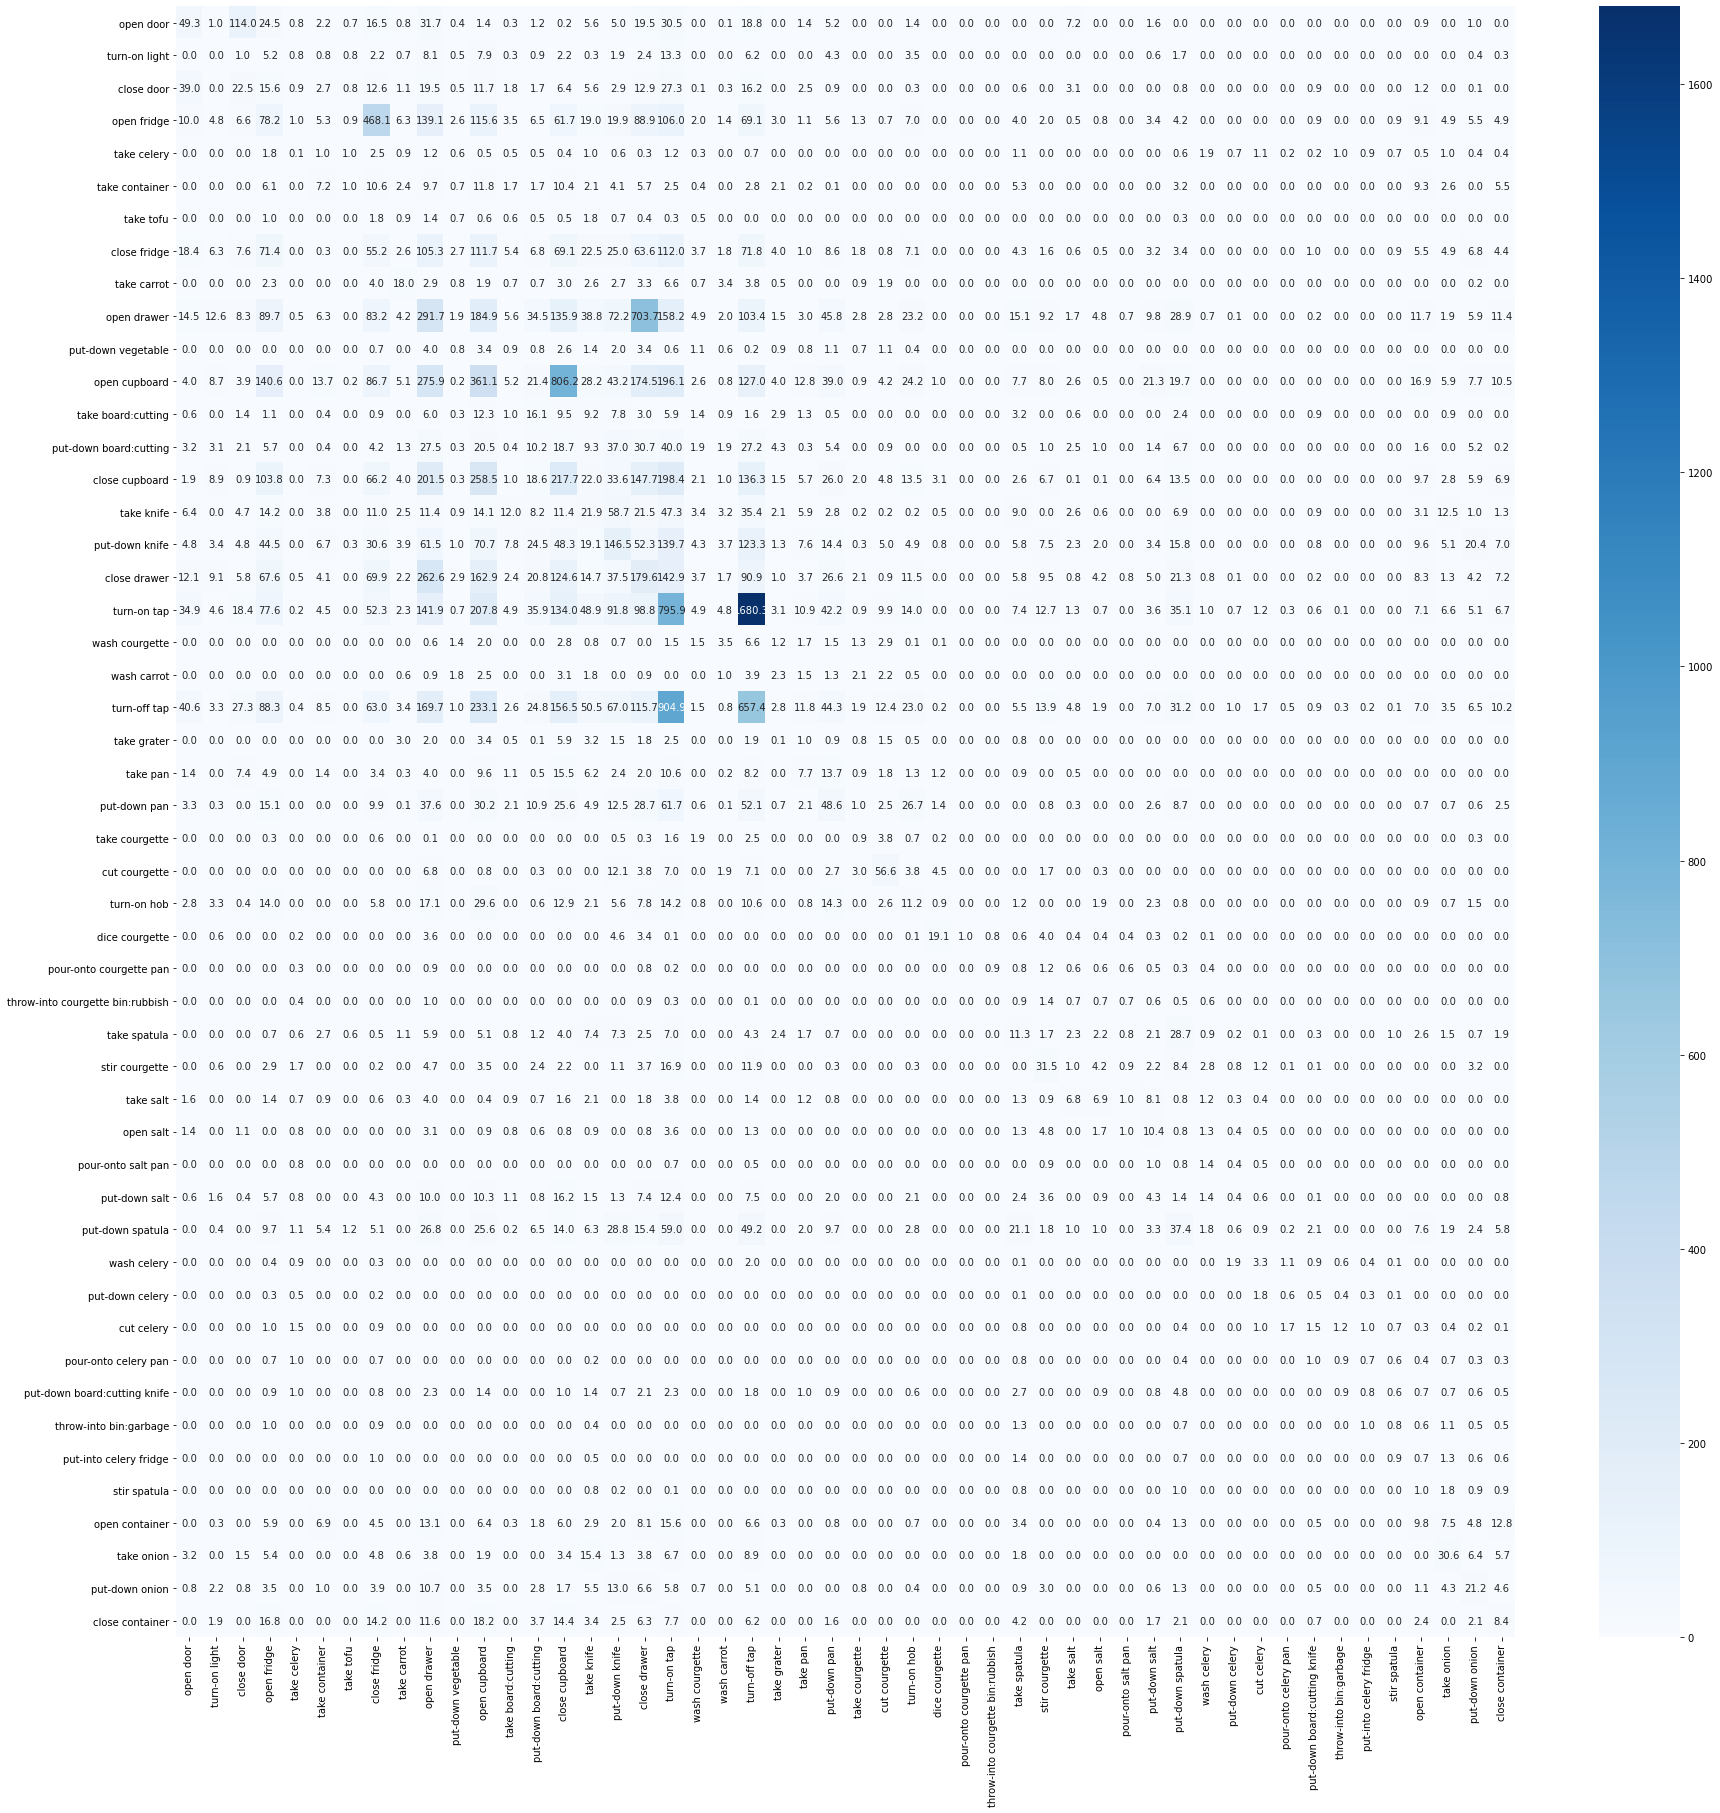

In [17]:
# Visualize causality matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm_keys = list(cm_pkl.keys())
k = 50
plt.figure(figsize=[30,30])
sns.heatmap(cm_array[:k, :k], annot=True, fmt=".1f", xticklabels=cm_keys[:k], yticklabels=cm_keys[:k], cmap='Blues')
plt.show()


## Get Matrix Stats

In [14]:
def get_causality_matrix_statistics(cm_array_l):
    '''
    Computes statistics for the causality matrix
    '''
    # Compute mean and standard deviation
    mean = np.mean(cm_array_l)
    std = np.std(cm_array_l)

    # Compute min and max
    min = np.min(cm_array_l)
    max = np.max(cm_array_l)

    # Compute median
    median = np.median(cm_array_l)

    # Compute quartiles
    q1 = np.percentile(cm_array_l, 25)
    q3 = np.percentile(cm_array_l, 75)

    # Compute range
    range = max - min

    # Compute interquartile range
    iqr = q3 - q1

    # Compute outliers
    # outliers = []
    # print(len(cm_array_l))
    # for i in np.arange(len(cm_array_l)):
    #     for j in np.arange(len(cm_array_l)):
    #         if cm_array_l[i][j] > q3 + 1.5 * iqr:
    #             outliers.append((i, j))

    return mean, std, min, max, median, q1, q3, range, iqr
    
def pretty_print_stats(stats):
    '''
    Prints the statistics for the causality matrix
    '''
    print('Mean:', stats[0])
    print('Standard deviation:', stats[1])
    print('Min:', stats[2])
    print('Max:', stats[3])
    print('Median:', stats[4])
    print('Q1:', stats[5])
    print('Q3:', stats[6])
    print('Range:', stats[7])
    print('IQR:', stats[8])
    # print('Outliers:', stats[9])


pretty_print_stats(get_causality_matrix_statistics(cm_array))

Mean: 0.003734166360049049
Standard deviation: 0.3127908174385907
Min: 0.0
Max: 1680.2805999999973
Median: 0.0
Q1: 0.0
Q3: 0.0
Range: 1680.2805999999973
IQR: 0.0


In [18]:
# Get percentage of zeros of causality matrix
print('Percentage of zeros:', np.count_nonzero(cm_array == 0) / len(cm_array) ** 2)

Percentage of zeros: 0.9972894689721395


In [13]:
# Get the top 10 values of causality matrix
top_10 = np.sort(cm_array.flatten())[-20:]
print(top_10)


# Get the indices of top 20 values of causality matrix
top_20_indices = np.argsort(cm_array.flatten())[-20:]
print(top_20_indices)

[ 284.2358  284.493   291.6792  298.6078  302.7371  307.2321  311.0169
  312.6169  342.3738  344.4422  361.101   423.7239  468.0778  518.6302
  657.4487  703.6951  795.9463  806.235   904.8933 1680.2806]
[ 9067602  9067605   122913  1639674   246472   245979 13028778 42869323
   286966  1638840   150227  8384850    40975 13027944   286797   122921
   245826   150230   286794   245829]


(array([5.02384e+05, 1.93300e+03, 5.31000e+02, 2.49000e+02, 1.15000e+02,
        5.50000e+01, 5.60000e+01, 2.60000e+01, 3.70000e+01, 1.60000e+01,
        1.10000e+01, 1.10000e+01, 7.00000e+00, 1.20000e+01, 3.00000e+00,
        6.00000e+00, 7.00000e+00, 2.00000e+00, 4.00000e+00, 0.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

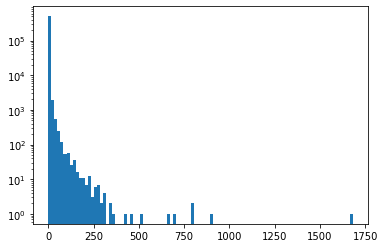

In [20]:
# Histogram of causality matrix values except 0 in logspace
plt.hist(cm_array.flatten()[cm_array.flatten() != 0], bins=100, log=True)
# plt.hist(cm_array.flatten()[cm_array.flatten() != 0], bins=100);


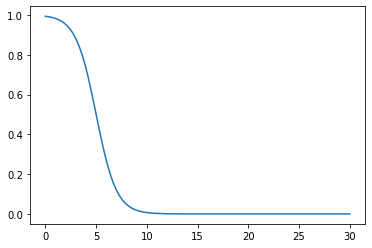

In [7]:
# Plot sigmoid
x = np.linspace(0, 30, 100)
plt.plot(x, sigmoid_decay(x))



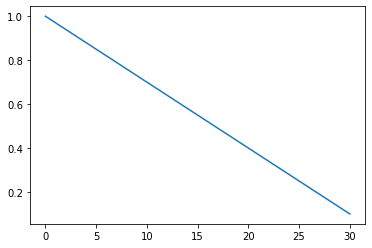

In [17]:
# plot linear decay
plt.plot(x, linear_decay(x))


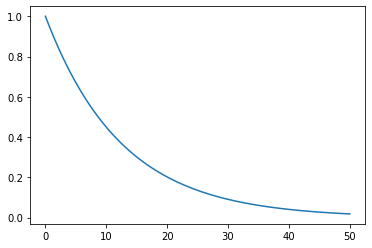

In [14]:
# plot exponential decay
x = np.linspace(0, 50, 100)
plt.plot(x, exp_decay_idx(x))

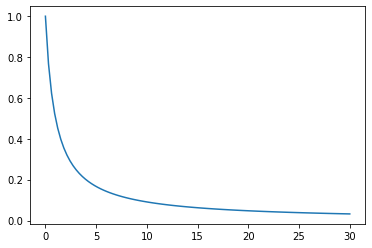

In [34]:
#plot inverse decay
plt.plot(x, inverse_decay(x))


## ToDo List

- Actions that always follow another action but never precede it
- What is the the distribution of “causality scores” (i.e. the values in the cells of the matrix)? What is the highest score, the lowest score, the average? A histogram would be a helpful way to visualize this.
    - [ ] Build histogram
    - 
- How many non-zero values are there typically in a row? That is, how many downstream actions generally follow a given action? Again, a histogram showing the frequency of the count of non-zero values across all the rows would work for this
    - 99th percentile is still zero
    - [ ] typical amount of zeros in rows
- Get list of actions that have almost no follow-up actions
- Similarity between actions based on their vectors
- Histogram for non-zero cells?
- Are there actions that constrain possible futures more?

# Notes

- physical constraints between events have lower variability
- while individual quirks have more var
- what's task specific, what's individual/location based?
- 

sort by frequency
which one has most density in first couple columns?
which one are highly regular actions?

distribution of when stuff will happen?


Look at distribution of times for specific actions
normalize the index approach by time of action

Can we treat this problem as representation building? Let a machine define the ordering?
Instance approach?
Matrix can allow us to get answer to cause questions